## Preambule

In [1]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Parameter

In [2]:
hist_startyear = 1990

## Paths

In [3]:
path_main = Path("X:/user/dekkerm/Projects/ECEMF_T5.2/")
path_data = path_main / "Data" / str(hist_startyear)
path_figs = path_main / "Figures"

## Read data files

In [4]:
xr_total = xr.open_dataset(path_data / "xr_total.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)
only_regions_iso = ['CVF', 'G20', "EU", "G7", "NA", "AU", "AF", "SIDS", "LDC", "WORLD"]
only_regions_names = ['Climate Vulnerability Forum','G20',"European Union","G7","Northern America","Australasia","African Group","Small Island Developing States","Least Developed Countries"]

In [5]:
xr_budgets_static = xr.open_dataset(path_data / "xr_budgets_static.nc")
xr_budgets_linear = xr.open_dataset(path_data / "xr_budgets_linear.nc")
xr_budgets_scenario = xr.open_dataset(path_data / "xr_budgets_scenario.nc")
df_michel = pd.read_excel(Path("X:/user/dekkerm/Data/") / "NDC" / "NDC_comparison.xlsx", sheet_name="Michel")

In [6]:
factor_lulucf = float(np.mean(xr_total.GHG_f_incl.sel(Time=2030)/xr_total.GHG_f.sel(Time=2030)))

## Derive relationship between cumulative GHG and temperature assessment

In [7]:
df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
df_ar6_data = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")

In [8]:
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
modcat = np.array([np.array(df_ar6_meta.ModelScenario), np.array(df_ar6_meta.Category)])
mods = np.array(df_ar6_data.Model)
scens = np.array(df_ar6_data.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_data['ModelScenario'] = modscens

In [9]:
df_ar6_new = df_ar6_data[df_ar6_data.Variable.isin(['Emissions|CO2',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile',
                                                    "Emissions|Kyoto Gases"
                                                    ])][['ModelScenario', 'Variable']+list(np.arange(2020, 2101).astype(str))]
df_ar6_new = df_ar6_new.reset_index(drop=True)
df_ar6_new = df_ar6_new.melt(id_vars = ["ModelScenario", 'Variable'], var_name='Time', value_name='Value')
df_ar6_new['Time'] = df_ar6_new['Time'].astype(int)
df_dummy = df_ar6_new.set_index(['ModelScenario', 'Variable', "Time"])
xr_ar6_new = xr.Dataset.from_dataframe(df_dummy)
xr_ar6_new = xr_ar6_new.reindex(Time = np.arange(2020, 2101))
xr_ar6_new = xr_ar6_new.interpolate_na(dim="Time", method="linear")

x:\user\dekkerm\environments\MyEnv\lib\site-packages\xarray\core\missing.py:264: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [10]:
modscens = np.array(xr_ar6_new.ModelScenario)
temperatures = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile", Time=2100).Value)
cumco2 = np.array(xr_ar6_new.sel(Variable = "Emissions|CO2").Value.sum(dim='Time'))

# Remove nans
nonans_temp = np.where(~np.isnan(temperatures))[0]
nonans_co2 = np.where(~np.isnan(cumco2))[0]
nonans = np.intersect1d(nonans_temp, nonans_co2)
modscens = modscens[nonans]
temperatures = temperatures[nonans]
cumco2 = cumco2[nonans]

# Linear regression
coef = np.polyfit(cumco2, temperatures, 1)

Text(0.5, 0, 'Cumulative CO2 (2020-2100)')

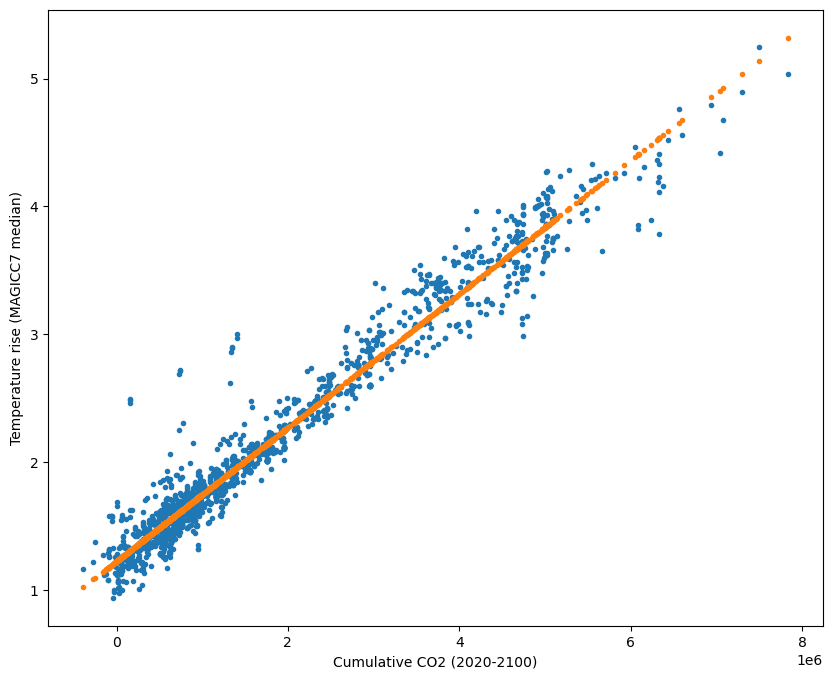

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(cumco2, temperatures, '.')
ax.plot(cumco2, cumco2*coef[0]+coef[1], '.')
ax.set_ylabel("Temperature rise (MAGICC7 median)")
ax.set_xlabel("Cumulative CO2 (2020-2100)")

In [12]:
modscens = np.array(xr_ar6_new.ModelScenario)
temperatures = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile", Time=2100).Value)
cumghg = np.array(xr_ar6_new.sel(Variable = "Emissions|Kyoto Gases").Value.sum(dim='Time'))

# Remove nans
nonans_temp = np.where(~np.isnan(temperatures))[0]
nonans_ghg = np.where(~np.isnan(cumghg))[0]
nonans = np.intersect1d(nonans_temp, nonans_ghg)
modscens = modscens[nonans]
temperatures = temperatures[nonans]
cumghg = cumghg[nonans]

# Remove zeros
nozero_ghg = np.where(cumghg > 0)[0]
modscens = modscens[nozero_ghg]
temperatures = temperatures[nozero_ghg]
cumghg = cumghg[nozero_ghg]

# Linear regression
coef_ghg = np.polyfit(cumghg, temperatures, 1)

Text(0.5, 0, 'Cumulative GHG (2020-2100)')

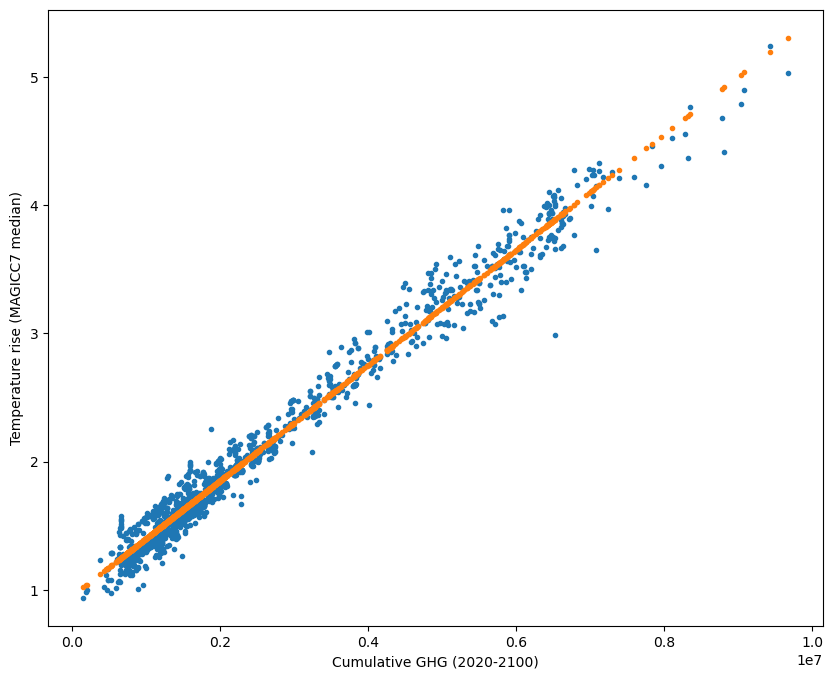

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(cumghg, temperatures, '.')
ax.plot(cumghg, cumghg*coef_ghg[0]+coef_ghg[1], '.')
ax.set_ylabel("Temperature rise (MAGICC7 median)")
ax.set_xlabel("Cumulative GHG (2020-2100)")

In [14]:
modscens = np.array(xr_ar6_new.ModelScenario)
temperatures = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile", Time=2100).Value)
temperatures5 = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile", Time=2100).Value)
temperatures95 = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile", Time=2100).Value)
ghg_2030 = np.array(xr_ar6_new.sel(Variable = "Emissions|Kyoto Gases", Time=2030).Value)

# Remove nans
nonans_temp = np.where(~np.isnan(temperatures))[0]
nonans_ghg = np.where(~np.isnan(ghg_2030))[0]
nonans = np.intersect1d(nonans_temp, nonans_ghg)
modscens = modscens[nonans]
temperatures = temperatures[nonans]
temperatures5 = temperatures5[nonans]
temperatures95 = temperatures95[nonans]
ghg_2030 = ghg_2030[nonans]

# Remove zeros
nozero_ghg = np.where(ghg_2030 > 0)[0]
modscens = modscens[nozero_ghg]
temperatures = temperatures[nozero_ghg]
temperatures5 = temperatures5[nozero_ghg]
temperatures95 = temperatures95[nozero_ghg]
ghg_2030 = ghg_2030[nozero_ghg]/factor_lulucf

# Linear regression
k = 3
coef_ghg_2030 = np.polyfit(ghg_2030, temperatures, k)

GF USA 0.1287912120043637
GF CHN 0.26628054866232403
GF EU 0.07716749061621674
PC USA 0.041483244912496886
PC CHN 0.16729408717885105
PC EU 0.05241566571532474
AP USA 0.09476285602606195
AP CHN 0.2831843002310153
AP EU 0.07121652075121238
GDR USA 0.052987134485313454
GDR CHN 0.3251420694265874
GDR EU 0.04301971679908737


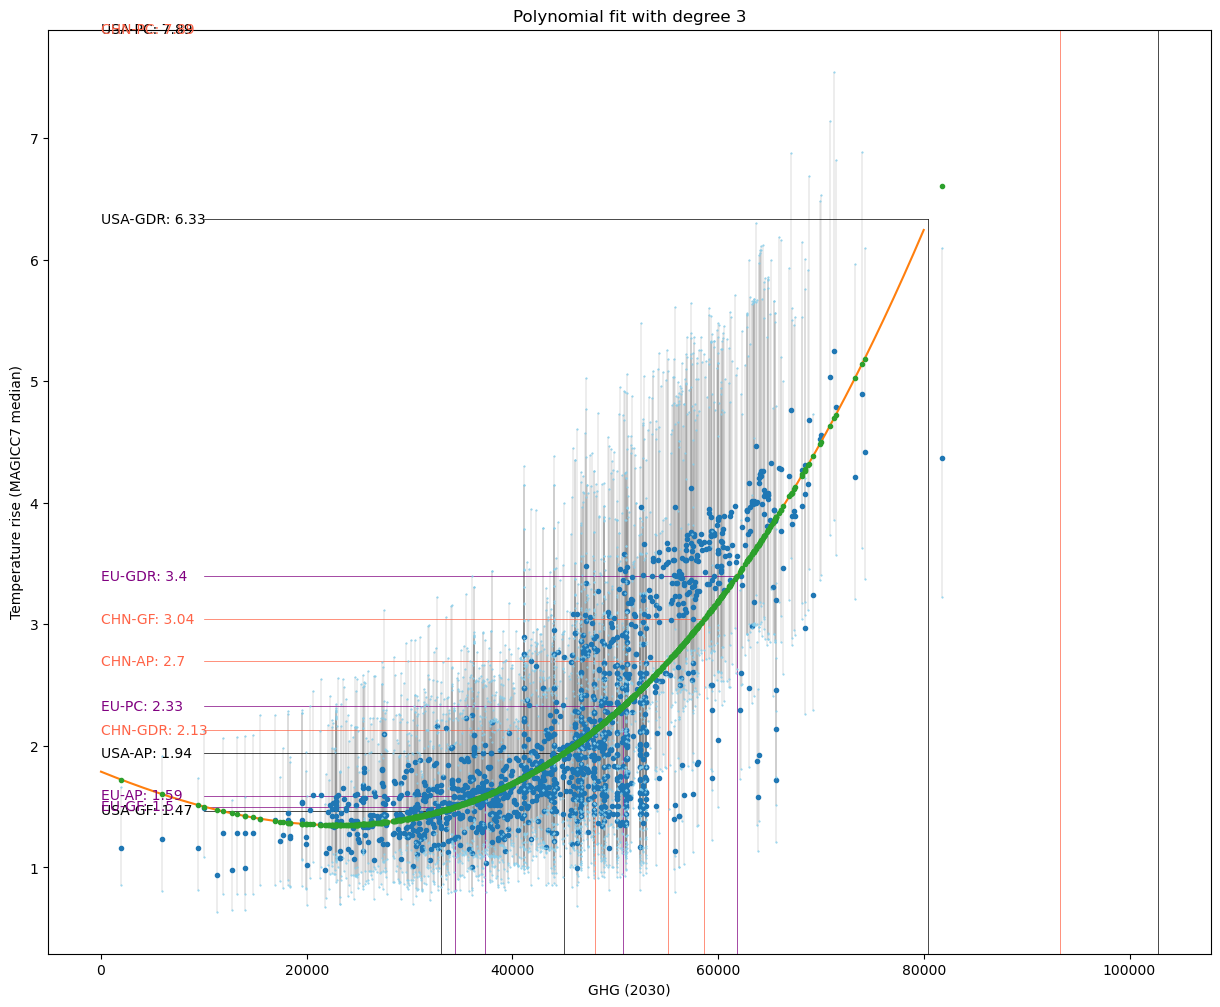

In [15]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(ghg_2030, temperatures, '.')
ax.plot(ghg_2030, temperatures5, '.', c='skyblue', ms=1)
ax.plot(ghg_2030, temperatures95, '.', c='skyblue', ms=1)
for i in range(len(ghg_2030)):
    ax.plot([ghg_2030[i], ghg_2030[i]], [temperatures5[i], temperatures95[i]], 'grey', lw=0.2, zorder=-1e9)
ax.set_ylim(ax.get_ylim())
ax.plot(np.arange(1, 80000., 10), np.sum([np.arange(1, 80000., 10)**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '-')
ax.plot(ghg_2030, np.sum([ghg_2030**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '.')
for var in ['GF', 'PC', 'AP', 'GDR']:
    for cty_i, cty in enumerate(['USA', 'CHN', 'EU']):
        perc = np.array(xr_budgets_scenario.sel(Time=2030, Variable = var, Region=cty).Value / xr_budgets_scenario.sel(Time=2030, Variable = "GF", Region='WORLD').Value).mean()
        print(var, cty, perc)
        ndc = float((xr_total.sel(ISO=cty, Time=2030).NDC_h+xr_total.sel(ISO=cty, Time=2030).NDC_l)/2)*1e3
        ndc_globalversion = ndc/perc
        inters = np.max([np.min([np.sum([ndc_globalversion**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), ax.get_ylim()[1]]), ax.get_ylim()[0]])
        ax.plot([ndc_globalversion, ndc_globalversion], [-1e3, inters], c=['k', 'tomato', 'purple'][cty_i], lw=0.5, zorder=-1e9)
        ax.plot([10000, ndc_globalversion], [inters, inters], c=['k', 'tomato', 'purple'][cty_i], lw=0.5, zorder=-1e9)
        ax.text(0, inters , cty+'-'+var+': '+str(np.round(inters, 2)), ha='left', c=['k', 'tomato', 'purple'][cty_i], va='center', fontsize=10)
ax.set_ylabel("Temperature rise (MAGICC7 median)")
ax.set_xlabel("GHG (2030)")
ax.set_title("Polynomial fit with degree "+str(k))
plt.show()

In [16]:
temps = np.zeros(shape=(4, len(all_countries_iso)))
for var_i, var in enumerate(['GF', 'PC', 'AP', 'GDR']):
    for cty_i, cty in enumerate(all_countries_iso):
        perc = np.array(xr_budgets_scenario.sel(Time=2030, Variable = var, Region=cty).Value / xr_budgets_scenario.sel(Time=2030, Variable = "GF", Region='WORLD').Value).mean()
        ndc = float((xr_total.sel(ISO=cty, Time=2030).NDC_h+xr_total.sel(ISO=cty, Time=2030).NDC_l)/2)*1e3
        ndc_globalversion = ndc/perc
        inters = np.sum([ndc_globalversion**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0)
        temps[var_i, cty_i] = inters

## Plot

In [17]:
fig = make_subplots(rows=5, cols=4, subplot_titles=('Grandfathering (GF)', 'Per Capita (PC)', 'Ability to pay (AP)', 'Greenhouse Development Rights'), 
                                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                                    horizontal_spacing = 0, vertical_spacing=0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(['GF', 'PC', 'AP', 'GDR']*5):
    if var_i == 0:
        cm= True
    else:
        cm= False
    fig.add_trace(
        go.Choropleth(
        locations=all_countries_iso,
        z = temps[np.mod(var_i, 4)],
        locationmode = 'ISO-3',
        colorscale = 'RdYlGn_r',
        zmax = 4,
        zmin = 1.5,
        text = [str(r)+": "+str(np.round(float(temps[np.mod(var_i, 4)][r_i]), 2))+" C" for r_i, r in enumerate(all_countries_iso)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='black', 
        colorbar=dict(len=1, x=1, tickvals = np.arange(1.5, 4, 0.25), title={"text":"Temperature<br>rise<br>associated<br>with NDC"}),
        showscale=cm
    ), [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5][var_i], [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4][var_i])
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo2 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo3 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo4 = dict(scope='europe', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo5 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo6 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo7 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo8 = dict(scope='africa', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),

    geo9 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo10 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo11 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo12 = dict(scope='asia', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo13 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo14 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo15 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo16 = dict(scope='south america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
                
    geo17 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo18 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo19 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo20 = dict(scope='north america', 
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
)
#fig.update_traces(showscale=False)
fig.update_layout(height=1400, width=1800)

In [18]:
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.svg")
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign_cont.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [19]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Grandfathering (GF)', 'Per Capita (PC)', 'Ability to pay (AP)', 'Greenhouse Development Rights'), 
                                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}]],
                                                    horizontal_spacing = 0, vertical_spacing=0.02)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(['GF', 'PC', 'AP', 'GDR']):
    if var_i == 0:
        cm= True
    else:
        cm= False
    t = np.copy(temps[np.mod(var_i, 4)])
    #t[t >= 4] = np.nan
    fig.add_trace(
        go.Choropleth(
        locations=all_countries_iso,
        z = t,
        locationmode = 'ISO-3',
        colorscale = 'RdYlGn_r',
        zmax = 4,
        zmin = 1.5,
        text = [str(r)+": "+str(np.round(float(t[r_i]), 2))+" C" for r_i, r in enumerate(all_countries_iso)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='white', 
        marker_line_width=0.3,
        colorbar=dict(len=1, x=1, tickvals = np.arange(1.5, 4, 0.25), title={"text":"Temperature<br>rise<br>associated<br>with NDC"}),
        showscale=cm
    ), [1, 1, 2, 2][var_i], [1, 2, 1, 2][var_i])
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_geos(visible=False,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                showcoastlines=False,)
#fig.update_traces(showscale=False)
fig.update_layout(height=1200, width=2100)

In [20]:
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.svg")
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [21]:
gf = np.copy(temps[0])
idx = np.argsort(gf)
gf_sort = gf[idx]
cs_sort = all_countries_iso[idx]

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_9764\1593217297.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



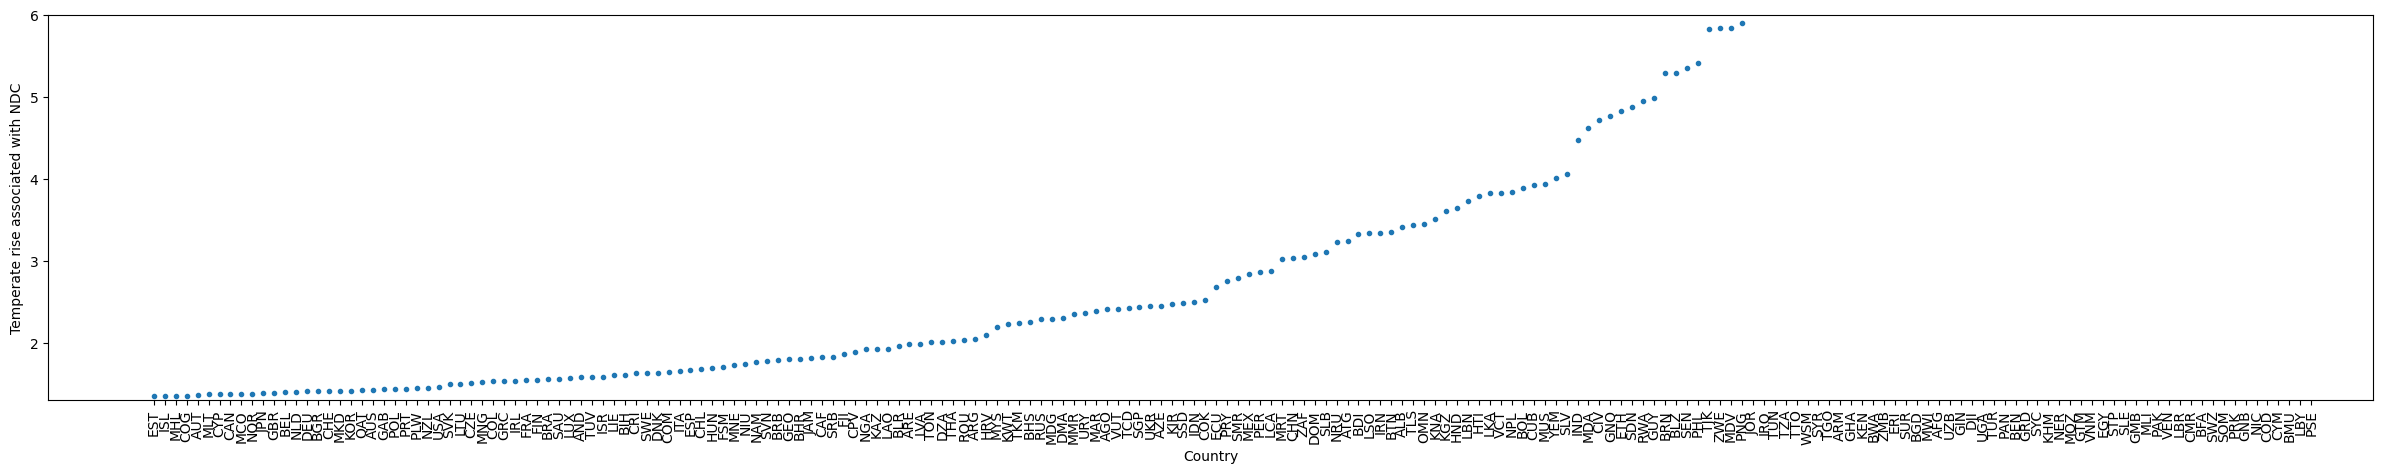

In [22]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(cs_sort, gf_sort, '.')
ax.set_ylim([1.3, 6])
ax.set_xlabel("Country") # Colour country by continent, .. etc.
ax.set_ylabel("Temperate rise associated with NDC")
ax.set_xticklabels(cs_sort, rotation = 90)
plt.show()